In [ ]:
_ = """
Copyright 2021 The Landsat Contrails Dataset Authors.

Licensed under the Apache License, Version 2.0 (the "License");                                                         
you may not use this file except in compliance with the License.                                                        
You may obtain a copy of the License at                                                                                 
                                                                                                                        
    https://www.apache.org/licenses/LICENSE-2.0                                                                         
                                                                                                                        
Unless required by applicable law or agreed to in writing, software                                                     
distributed under the License is distributed on an "AS IS" BASIS,                                                       
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.                                                
See the License for the specific language governing permissions and                                                     
limitations under the License.
"""

In [1]:
import collections
import copy
import numpy as np
import json
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import measurements
import skimage.exposure
from sklearn import linear_model
from typing import Any, Dict, Iterable, List, Mapping, Optional, Tuple

In [3]:
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
import gdal
import gdalconst

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [ ]:
!gsutil cp gs://landsat_contrails_dataset/2021_06_11_1623455786/data/demo_shard.json /tmp/demo_shard.json

with open('/tmp/demo_shard.json') as f:
  scene_data = json.loads(f.read())

In [5]:
def path_from_filename(landsat_filename):
  """Returns the full GCP filepath for the provided `landsat_filename`.

  An example filename looks like:
  LC08_L1TP_221074_20181218_20181227_01_T1_B10.TIF

  The returned path ends up looking like:
  gs://gcp-public-data-landsat/LC08/01/221/074/LC08_L1TP_221074_20181218_20181227_01_T1/LC08_L1TP_221074_20181218_20181227_01_T1_B10.TIF

  Args:
    landsat_filename: str, file name of a landsat scene.
  Returns:
    str, full path to the corresponding landsat scene.
  """
  split_name = landsat_filename.split('_')
  path, row = split_name[2][:3], split_name[2][3:]
  bands = split_name[0]  # Either LC08 or LT08
  parent_dir = '_'.join(split_name[:-1])
  return os.path.join(f'gs://gcp-public-data-landsat/{bands}/01/',
                      path, row, parent_dir, landsat_filename)

In [6]:
filename_11um = 'LC08_L1TP_036037_20180406_20180417_01_T1_B10.TIF'
filename_12um = filename_11um.replace('B10.TIF', 'B11.TIF')
filename_1370nm = filename_11um.replace('B10.TIF', 'B9.TIF')
filename_red =  filename_11um.replace('B10.TIF', 'B4.TIF')
filename_green =  filename_11um.replace('B10.TIF', 'B3.TIF')
filename_blue =  filename_11um.replace('B10.TIF', 'B2.TIF')
filename_mtl = filename_11um.replace('B10.TIF', 'MTL.txt')

!gsutil cp {path_from_filename(filename_11um)} /tmp/
!gsutil cp {path_from_filename(filename_12um)} /tmp/
!gsutil cp {path_from_filename(filename_1370nm)} /tmp/
!gsutil cp {path_from_filename(filename_red)} /tmp/
!gsutil cp {path_from_filename(filename_green)} /tmp/
!gsutil cp {path_from_filename(filename_blue)} /tmp/
!gsutil cp {path_from_filename(filename_mtl)} /tmp/

path_11um = os.path.join('/tmp/', filename_11um)
path_12um = os.path.join('/tmp/', filename_12um)
path_1370nm = os.path.join('/tmp/', filename_1370nm)
path_red = os.path.join('/tmp/', filename_red)
path_green = os.path.join('/tmp/', filename_green)
path_blue = os.path.join('/tmp/', filename_blue)
path_mtl = os.path.join('/tmp/', filename_mtl)

Copying gs://gcp-public-data-landsat/LC08/01/036/037/LC08_L1TP_036037_20180406_20180417_01_T1/LC08_L1TP_036037_20180406_20180417_01_T1_B10.TIF...
\ [1 files][ 60.0 MiB/ 60.0 MiB]                                                
Operation completed over 1 objects/60.0 MiB.                                     
Copying gs://gcp-public-data-landsat/LC08/01/036/037/LC08_L1TP_036037_20180406_20180417_01_T1/LC08_L1TP_036037_20180406_20180417_01_T1_B11.TIF...
- [1 files][ 57.8 MiB/ 57.8 MiB]                                                
Operation completed over 1 objects/57.8 MiB.                                     
Copying gs://gcp-public-data-landsat/LC08/01/036/037/LC08_L1TP_036037_20180406_20180417_01_T1/LC08_L1TP_036037_20180406_20180417_01_T1_B9.TIF...
- [1 files][ 48.9 MiB/ 48.9 MiB]                                                
Operation completed over 1 objects/48.9 MiB.                                     
Copying gs://gcp-public-data-landsat/LC08/01/036/037/LC08_L1TP_036037_2018

In [7]:
def raster_image(tif, downsample_factor=10):
  """Returns the raster images, possibly downsampled.

  Args:
    tif: GeoTIFF image of landsat band.
    downsample_factor: float or int, how many times smaller to downsample to.

  Returns:
    Rastered version of the band.
  """
  # First read is just to get shape, so we can do the second read properly.
  data = tif.ReadAsArray()
  data = tif.ReadAsArray(
      buf_xsize=int(data.shape[1] / downsample_factor),
      buf_ysize=int(data.shape[0] / downsample_factor),
      resample_alg=gdalconst.GRIORA_Average)
  data = np.where(data == 0, np.nan, data)
  return data


def parse_metadata(path_mtl):
  """Returns parsed metadata.

  Args:
    path: path to a local MTL.txt file.

  Raises:
    OSError: if the metadata is missing.

  Returns:
    metadata dict
  """
  if not os.path.exists(path_mtl):
    raise OSError('Missing file: ' + path_mtl)

  metadata = {}
  with open(path_mtl) as f:
    for line in f:
      if ' = ' in line:
        split_line = line.split(' = ')
        try:
          metadata[split_line[0].strip()] = float(split_line[-1].strip())
        except ValueError:
          metadata[split_line[0].strip()] = split_line[-1].strip()
  return metadata


# Constants to use when converting radiance to temperature via the Planck
# equation: https://en.wikipedia.org/wiki/Planck%27s_law
# k1=2hc^2/lambda^5, and k2=hc/lambda k_B, with lambda=wavelength and
# k_B=Boltzmann's constant. Actual satellites also include small calibration
# factors, here called mult and add.
BandConstants = collections.namedtuple('BandConstants',
                                       ['mult', 'add', 'k1', 'k2'])
RADIANCE_ADD_KEY = 'RADIANCE_ADD_BAND_'
RADIANCE_MULT_KEY = 'RADIANCE_MULT_BAND_'
REFLECTANCE_ADD_KEY = 'REFLECTANCE_ADD_BAND_'
REFLECTANCE_MULT_KEY = 'REFLECTANCE_MULT_BAND_'
K1_KEY = 'K1_CONSTANT_BAND_'
K2_KEY = 'K2_CONSTANT_BAND_'


def read_band_constants(metadata,
                        band,
                        reflectance=True):
  """Extract band constants from Landsat Metadata.

  Args:
    metadata: Metadata from the LandSat file.
    band: name of the band to get constants for.
    reflectance: if True, read constants for reflectance rather than
      temperature.

  Returns:
    A BandConstants object containing the constants.
  """
  if reflectance:
    return BandConstants(metadata[REFLECTANCE_MULT_KEY + band],
                         metadata[REFLECTANCE_ADD_KEY + band],
                         None, None)
  else:
    return BandConstants(metadata[RADIANCE_MULT_KEY + band],
                         metadata[RADIANCE_ADD_KEY + band],
                         metadata[K1_KEY + band],
                         metadata[K2_KEY + band])  


def top_of_atmosphere_temperature(image, band_constants):
    """Conversion of radiances to brightness temperature.

    Described here:
    https://www.usgs.gov/core-science-systems/nli/landsat/using-usgs-landsat-level-1-data-product

    Args:
      image: np.ndarray, radiance to convert to brightness temperature.
      band_constants: constants needed by the conversion.

    Returns:
      np.ndarray of brightness temperature (units of K).
    """
    radiance = image * band_constants.mult
    radiance += band_constants.add
    denom = np.log((band_constants.k1 / radiance) + 1.)
    return band_constants.k2 / denom


def reflectance(image, band_constants):
    return image * band_constants.mult + band_constants.add    


def normalize_for_rgb(signal,
                      bounds,
                      adapt=True) -> np.ndarray:
  """Map an array to (0, 1)."""
  start, end = bounds
  out = ((signal - start) / (end - start)).clip(0, 1)
  if (np.all(np.isnan(out) | np.isclose(out, 0, atol=1e-3)) or
      np.all(np.isnan(out) | np.isclose(out, 1, atol=1e-3))):
    adapt = False
  if adapt:
    out = skimage.exposure.equalize_adapthist(out, clip_limit=0.03)
  return out


def get_false_color_image(
    path_11um, path_12um, path_1370nm, path_mtl, night=False):
  """Creates a false color image, as shown to the contrail labelers."""      

  tif_11um = gdal.Open(path_11um)
  tif_12um = gdal.Open(path_12um)
  tif_1370nm = gdal.Open(path_1370nm)

  radiance_11um = raster_image(tif_11um)
  radiance_12um = raster_image(tif_12um)
  radiance_1370nm = raster_image(tif_1370nm)

  del tif_11um
  del tif_12um
  del tif_1370nm

  metadata = parse_metadata(path_mtl)
  constants_11um = read_band_constants(metadata, '10', reflectance=False)
  constants_12um = read_band_constants(metadata, '11', reflectance=False)
  constants_1370nm = read_band_constants(metadata, '9', reflectance=True)  

  temperature_11um = top_of_atmosphere_temperature(radiance_11um, constants_11um)
  temperature_12um = top_of_atmosphere_temperature(radiance_12um, constants_12um)
  reflectance_1370nm = reflectance(radiance_1370nm, constants_1370nm)

  tdiff = temperature_11um - temperature_12um

  # The red band is negative of the brightness temperature difference
  # (so 1 means no brightness temperature difference, 0 means large
  # brightness temperature difference)
  tdiff_clip = (-1, 5.5)  
  tdiff_bounds = (-tdiff_clip[1], -tdiff_clip[0])
  ir_r = normalize_for_rgb(-1 * tdiff, tdiff_bounds, adapt=False)

  # The green band is 1 - cirrus reflectance. So zero means the cirrus band
  # is highly reflective (indicating the presence of cirrus clouds), 1 means
  # the cirrus band is not reflective.
  if night:
    ir_g = np.zeros_like(reflectance_1370nm)
    t12_bounds = (243, 303)  # From a sample of nighttime landsat scenes.
  else:
    ir_g = normalize_for_rgb(1 - reflectance_1370nm, bounds=(0.8, 1))
    t12_bounds = (283, 303)  # From a sample of daytime landsat scenes.

  # The blue band is the 12 um brightness temperature. Zero means cold,
  # (which is consistent with contrails), one means hot, so probably not a
  # contrail.
  ir_b = normalize_for_rgb(temperature_12um, t12_bounds)
  
  return np.stack([ir_r, ir_g, ir_b], axis=-1), temperature_11um, temperature_12um, reflectance_1370nm

false_color_image, temperature_11um, temperature_12um, reflectance_1370nm = get_false_color_image(path_11um, path_12um, path_1370nm, path_mtl)

In [8]:
TWELVE_MICRONS = 'temperature_12um'
TDIFF = 'brightness_temperature_difference'

def lowpass(image, config):
  """Applies a gaussian lowpass kernel."""
  # The Mannstein et al paper doesn't give enough information about this kernel
  # to reproduce it exactly, it just says "Gaussian 5x5 pixel lowpass kernel",
  # so the gaussian parameters come from config so they can get tuned
  # by blackbox optimization.
  kernel_size_pixels = config['lowpass_kernel_size_pixels']
  pixels_per_sigma = config['lowpass_kernel_pixels_per_sigma']
  units_per_sigma = pixels_per_sigma / kernel_size_pixels
  n1, n2 = np.meshgrid(
      np.linspace(-1, 1, kernel_size_pixels),
      np.linspace(-1, 1, kernel_size_pixels))
  distance_from_center = np.sqrt(np.square(n1) + np.square(n2))
  gaussian = (1 / (units_per_sigma * np.sqrt(2 * np.pi)) *
              (np.exp(-np.square(distance_from_center / units_per_sigma) / 2)))
  gaussian_kernel = gaussian / gaussian.sum()
  return signal.convolve2d(image, gaussian_kernel, mode='same')


def synthesize_line_kernel(degrees, config):
  """Returns a kernel for line detection at the specified angle in `degrees`."""
  size = config['line_kernel_size_pixels']
  radians = degrees * (np.pi / 180.)
  n1, n2 = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))

  # d is the distance of each point from the line with slope `radians`
  # which passes through the origin.
  # The formula below for `d` is derived as follows:
  # If you rotated the line by multiplying it with
  # the standard 2D rotation matrix R = [[cos r, -sin r], [sin r, cos r]],
  # it would become an entirely vertical line (x=0).
  # If you did the same thing to all the points in the kernel field,
  # then their x-coordinate becomes the distance from the line. Then:
  # np.dot(R, [n1, n2])[0] = n1 * cos(r) - n2 * sin(r)
  d = (n1 * np.cos(radians)) - (n2 * np.sin(radians))

  pixels_per_sigma1 = config['line_kernel_pixels_per_sigma1']
  pixels_per_sigma2 = (
      pixels_per_sigma1 + config['line_kernel_pixels_per_sigma_delta'])
  units_per_sigma1 = (pixels_per_sigma1 / config['line_kernel_size_pixels'])
  gaussian1 = ((1 / (units_per_sigma1 * np.sqrt(2 * np.pi))) *
               (np.exp(-np.square(d / units_per_sigma1) / 2)))
  units_per_sigma2 = (pixels_per_sigma2 /
                      config['line_kernel_size_pixels'])
  gaussian2 = ((1 / (units_per_sigma2 * np.sqrt(2 * np.pi))) *
               (np.exp(-np.square(d / units_per_sigma2) / 2)))
  difference_of_gaussians = gaussian1 - gaussian2
  return zero_sum_normalize(difference_of_gaussians)


def zero_sum_normalize(kernel: np.ndarray) -> np.ndarray:
  """Normalizes kernels that are intentionally symmetrical around 0.

  Difference of Gaussians and Prewitt operators (among others) are zero-summing,
  so we normalize the positive and negative values separately, as suggested by
  http://www.imagemagick.org/Usage/convolve/#zero-summing_normalization.

  Args:
    kernel: 2D numpy array.

  Returns:
    Zero-sum normalized kernel.
  """
  pos_sum = np.sum(
      np.where(kernel > 0, kernel, 0))
  neg_sum = -np.sum(
      np.where(kernel <= 0, kernel, 0))
  return np.where(kernel > 0, kernel / pos_sum, kernel / neg_sum)


def get_regional_gradient_mask(t_12um: np.ndarray,
                               t_12um_stddev: np.ndarray,
                               config: Mapping[str, Any]) -> np.ndarray:
  """Masks out pixels on the edges of large features.

  There's a lot of ways to implement a "large scale gradient",
  and the Mannstein et al paper only specifies the size: 15px.
  Here we use a blurred Prewitt operator because it's the simplest
  to implement at varying kernel sizes for later tuning.
  https://en.wikipedia.org/wiki/Prewitt_operator.

  Args:
    t_12um: array of 12 um temperature.
    t_12um_stddev: stddev of above array.
    config: algorithm configuration parameters (eg thresholds).
  Returns:
    boolean array of whether the pixel is part of a large scale gradient,
      and therefore is not a contrail.
  """

  mean_kernel = np.ones(config['prewitt_operator_size_pixels'], dtype=np.int)
  gradient_kernel = np.concatenate([
      np.ones(config['prewitt_operator_smoothing_pixels'], dtype=np.int),
      np.zeros(
          config['prewitt_operator_size_pixels'] -
          2 * config['prewitt_operator_smoothing_pixels'],
          dtype=np.int),
      -np.ones(config['prewitt_operator_smoothing_pixels'], dtype=np.int)
  ])
  prewitt_col = np.outer(mean_kernel, gradient_kernel)
  # Zero-sum normalize it to keep the gradient in units of Kelvin,
  # for later applying equation (5).
  prewitt_col = zero_sum_normalize(prewitt_col)
  prewitt_row = prewitt_col.T
  gradient_row = signal.convolve2d(t_12um, prewitt_row, mode='same')
  gradient_col = signal.convolve2d(t_12um, prewitt_col, mode='same')
  t_12um_regional_gradient = np.sqrt(
      np.square(gradient_row) + np.square(gradient_col))
  return (t_12um_regional_gradient <
          (config['regional_gradient_max_scale'] * t_12um_stddev) +
          config['regional_gradient_max_offset'])


def mannstein_one_angle_mask(features: Dict[str, np.ndarray],
                             config: Mapping[str, Any],
                             degrees: float) -> np.ndarray:
  """Returns mask identifying contrail pixels.

  Args:
    features: dict containing 11um and 12um brightness temperatures.
    config: algorithm configuration parameters (eg thresholds).
    degrees: the angle to detect contrails for.

  Returns:
    Array which is 1 where a pixel is on a contrail and 0 elsewhere.
  """
  t_12um = features[TWELVE_MICRONS]
  difference = features[TDIFF]

  t_12um_inverse = -t_12um

  t_12um_inverse_smoothed = lowpass(t_12um_inverse, config)
  difference_smoothed = lowpass(difference, config)

  t_12um_inverse_signal = t_12um_inverse - t_12um_inverse_smoothed
  difference_signal = difference - difference_smoothed

  t_12um_inverse_stddev = lowpass(
      np.sqrt(np.square(t_12um_inverse_signal)), config)
  difference_stddev = lowpass(np.sqrt(np.square(difference_signal)), config)

  t_12um_inverse_normalized = t_12um_inverse_signal / (
      t_12um_inverse_stddev + config['stddev_epsilon'])
  difference_normalized = difference_signal / (
      difference_stddev + config['stddev_epsilon'])

  t_12um_inverse_clipped = np.clip(t_12um_inverse_normalized,
                                   -config['normalized_clip_magnitude'],
                                   config['normalized_clip_magnitude'])
  difference_clipped = np.clip(difference_normalized,
                               -config['normalized_clip_magnitude'],
                               config['normalized_clip_magnitude'])

  normalized_sum = t_12um_inverse_clipped + difference_clipped

  line_kernel = synthesize_line_kernel(degrees, config)
  detected_lines = signal.convolve2d(normalized_sum, line_kernel, mode='same')

  if 'regional_gradient_max_scale' in config:
    regional_gradient_mask = get_regional_gradient_mask(
        t_12um, t_12um_inverse_stddev, config)
  else:
    regional_gradient_mask = np.ones_like(detected_lines, dtype=np.bool)

  # `detected_lines` is the 'smallest' image because it has had the most
  # convolutions passed over it, and the np.nan values surrounding the
  # finite pixels has increased in size due to that, so
  # we mask off all the images to this smallest size.
  normalized_sum = np.where(np.isfinite(detected_lines), normalized_sum, np.nan)
  difference = np.where(np.isfinite(detected_lines), difference, np.nan)
  regional_gradient_mask = np.where(
      np.isfinite(detected_lines), regional_gradient_mask, False)

  line_mask = (
      (detected_lines > config['normalized_sum_threshold']) &
      (normalized_sum > config['normalized_sum_threshold']) &
      (difference > config['temperature_difference_threshold']) &
      regional_gradient_mask)

  line_mask = np.where(np.isfinite(detected_lines), line_mask, np.nan)
  return line_mask


def get_angles(config: Mapping[str, Any]) -> np.ndarray:
  """Gets the list of angles from a config.

  Args:
    config: the config
  Returns:
    the angles.
  """
  return np.linspace(0, 180, config['num_line_kernels'], endpoint=False)


def label_blobs(line_mask: np.ndarray,
                config: Dict[str, Any]
                ) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
  """Given a mask, yields pixel coordinates of connected components.

  Args:
    line_mask: 2d array, 1 when there is a contrail 0 otherwise.
    config: params for what is an allowable contrail.
  Yields:
    Tuple of (row_coordinates, col_coordinates).
  """

  # measurements.label interprets np.nan as different from zero, so it thinks
  # nan's are contrail pixels. Replace all nans with zeros so we only label
  # the non-nan pixels as contrails
  line_mask = np.where(np.isnan(line_mask), 0, line_mask)
  labels, _ = measurements.label(line_mask, structure=np.ones((3, 3)))
  bincount = np.bincount(labels.flatten())
  right_sized_labels, = (
      (bincount > config['min_contrail_num_pixels']) &
      (bincount < config['max_contrail_num_pixels'])).nonzero()

  for label in right_sized_labels:
    yield (labels == label).nonzero()


def linear_fit(xs, ys):
  train_ys = ys.reshape(-1, 1)
  train_xs = xs.reshape(-1, 1)
  regression = linear_model.LinearRegression().fit(train_xs, train_ys)
  return (regression.score(train_xs, train_ys), regression.coef_[0][0],
          regression.intercept_[0])


def linear_and_long_enough(ys: np.ndarray, xs: np.ndarray,
                           config: Dict[str, Any],
                           avg_size: int = 3,
                           round_to_int: bool = True) -> bool:
  """Decides if a connected component is linear and long enough for a contrail.

  Does this by performing a linear fit to all the passed in pixels. Note that
  if the pixels are a vertically-oriented rectangle, the 'best fit line' will
  have a slope of infinity, but your average linear fitter really doesn't like
  making an infinite slope. So in this method we decide whether to use
  x or y as the independent variable, in such a way as to minimize the slope
  before doing any fitting (e.g. for mostly vertical clusters, we fit
  x = f(y), for mostly horizontal we fit y = f(x).

  Args:
    ys: pixel row coordinates
    xs: pixel col coordinates
    config: Dict containing params for what makes a contrail
    avg_size: Below we handle top/bottom or left/right endpoints separately,
      based on the slope. To reduce noise from extremal pixel locations,
      take the average of a small number of extremal pixels as the endpoint.
  Returns:
    True if the pixel blob meets config-defined linearity and size thresholds.
  """

  sorted_indices = np.argsort(ys)
  y1 = np.mean(ys[sorted_indices][:avg_size])
  y2 = np.mean(ys[sorted_indices][-avg_size:])
  sorted_indices = np.argsort(xs)
  x1 = np.mean(xs[sorted_indices][:avg_size])
  x2 = np.mean(xs[sorted_indices][-avg_size:])

  if abs(x1 - x2) > abs(y1 - y2):
    # This is a horizontal-ish line; use x as independent variable.
    score, slope, intercept = linear_fit(xs=xs, ys=ys)
    y1 = x1 * slope + intercept
    y2 = x2 * slope + intercept
    pixel_length = np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))
  else:
    # This is a vertical-ish line; use y as independent variable.
    score, slope, intercept = linear_fit(xs=ys, ys=xs)
    x1 = y1 * slope + intercept
    x2 = y2 * slope + intercept
    pixel_length = np.sqrt(np.square(y1 - y2) + np.square(x1 - x2))

  return (score > np.square(config['min_linear_regression_r_score']) and
      pixel_length > config['min_contrail_pixel_length'])


def find_contrail_pixels(
    line_mask: np.ndarray, config: Dict[str, Any]
) -> List[Tuple[np.ndarray, np.ndarray]]:
  """Returns lat/lng endpoints of all contrails in line_mask.

  Args:
    line_mask: np.array, binary mask of where contrail lines were detected.
    config: dict, algorithm configuration parameters (eg thresholds).

  Returns:
    List of (row pixel coordinates, col pixel coordinates) tuples.
  """
  contrail_pixel_coords = []
  for rows, cols in label_blobs(line_mask, config):
    if not linear_and_long_enough(rows, cols, config):
      continue
    contrail_pixel_coords.append((rows, cols))
  return contrail_pixel_coords        


def mannstein_contrail_mask(
    features: Dict[str, np.ndarray], config: Mapping[str, Any]
) -> np.ndarray:
  """Mannstein et al contrail detection algorithm.

  See "Operational detection of contrails from NOAA-AVHRR-data",
  International Journal of Remote Sensing, 1999:
  https://www.tandfonline.com/doi/abs/10.1080/014311699212650

  Args:
    features: dict containing 11um-12um and 12um brightness temperatures.
    config: algorithm configuration parameters (eg thresholds).

  Returns:
    Mask, pixels identified as contrails are 1 and everywhere else is 0.
  """
  contrail_mask = np.zeros_like(features[TDIFF], dtype=np.int)
  for degrees in get_angles(config):
    line_mask = mannstein_one_angle_mask(features, config, degrees)
    for rows, cols in find_contrail_pixels(line_mask, config):
      contrail_mask[rows, cols] = 1
  return contrail_mask     

features = {
    TWELVE_MICRONS: temperature_12um,
    TDIFF: temperature_11um - temperature_12um,
}

config = {
  "stddev_epsilon": 0.1,
  "normalized_clip_magnitude": 2.0,
  "normalized_sum_threshold": 1,             # Tuned
  "temperature_difference_threshold": 1.33,  # Tuned
  "max_contrail_num_pixels": 1000,
  "min_contrail_num_pixels": 11,             # Tuned
  "min_contrail_pixel_length": 14,           # Tuned
  "min_linear_regression_r_score": 0.25,
  "num_line_kernels": 16,                    # Tuned
  "line_kernel_size_pixels": 19,
  "line_kernel_pixels_per_sigma1": 1,        # Tuned
  "line_kernel_pixels_per_sigma_delta": 2,   # Tuned
  "lowpass_kernel_pixels_per_sigma": 3.88,   # Tuned
  "lowpass_kernel_size_pixels": 5,
  "prewitt_operator_size_pixels": 15,        # Tuned
  "prewitt_operator_smoothing_pixels": 3,
  "regional_gradient_max_scale": 2.0,
  "regional_gradient_max_offset": 1.0        # Tuned
}

mannstein_mask = mannstein_contrail_mask(features, config)    

In [9]:
def truecolor_rgb(path_red, path_green, path_blue):
  """Given Landsat red, green & blue filepaths, return an image for plotting."""
  
  tif_red = gdal.Open(path_red)
  tif_green = gdal.Open(path_green)
  tif_blue = gdal.Open(path_blue)

  radiance_red = raster_image(tif_red)
  radiance_green = raster_image(tif_green)
  radiance_blue = raster_image(tif_blue)

  del tif_red
  del tif_green
  del tif_blue

  rgb = np.stack([radiance_red, radiance_green, radiance_blue], axis=-1)
  # Landsat gives us the radiance as a 16-bit integer, convert to
  # float in (0, 1).
  rgb = rgb / (2**16 - 1)
  # This routine increases the contrast on dark/bright parts of the image.
  for i in range(3):
    rgb[..., i] = skimage.exposure.equalize_adapthist(
        rgb[..., i], clip_limit=0.1)
  return rgb

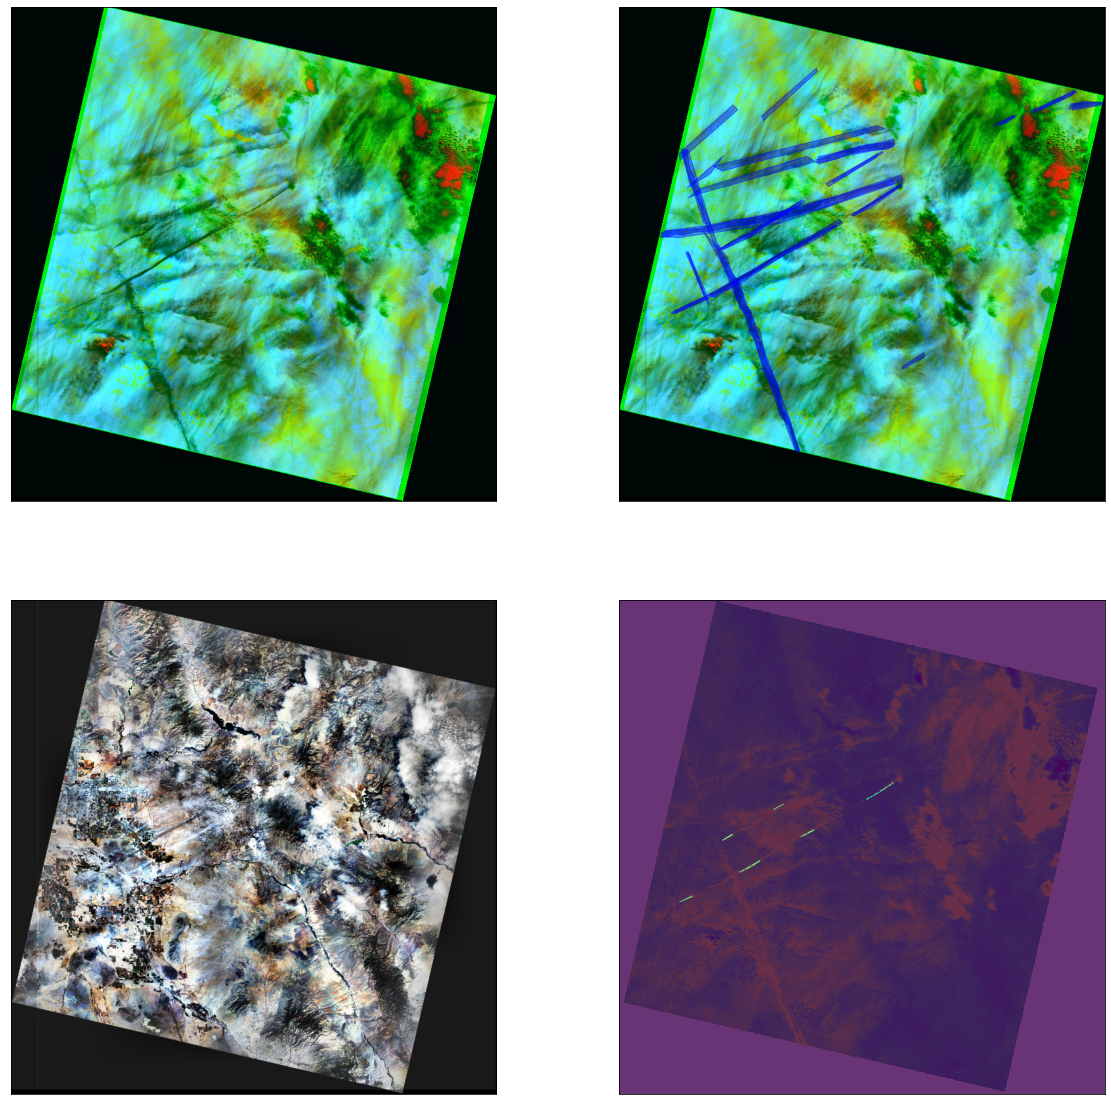

In [10]:
plt.figure(figsize=(20, 20))

def plot(image, ax):
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])

# False color shown to labelers.
plot(false_color_image, plt.subplot(2, 2, 1))

# False color with labels overlaid.
ax = plt.subplot(2, 2, 2)
plot(false_color_image, ax)
patches = []
for polygon in scene_data['polygons']:
  patches.append(matplotlib.patches.Polygon(np.array(polygon), True, color=[0, 0, 1]))
p = matplotlib.collections.PatchCollection(patches, alpha=0.4, match_original=True)
ax.add_collection(p)

# True color RGB.
rgb = truecolor_rgb(path_red, path_green, path_blue)
ax = plt.subplot(2, 2, 3)
plot(rgb, ax)                 

# Temperature difference with contrail pixels 
# identified by Mannstein et al algorithm overlaid.
ax = plt.subplot(2, 2, 4)
tdiff_clip = (-1, 5.5)  
tdiff = normalize_for_rgb(features[TDIFF], tdiff_clip, adapt=False)
plot(tdiff, ax)
ax.imshow(mannstein_mask, alpha=0.8)

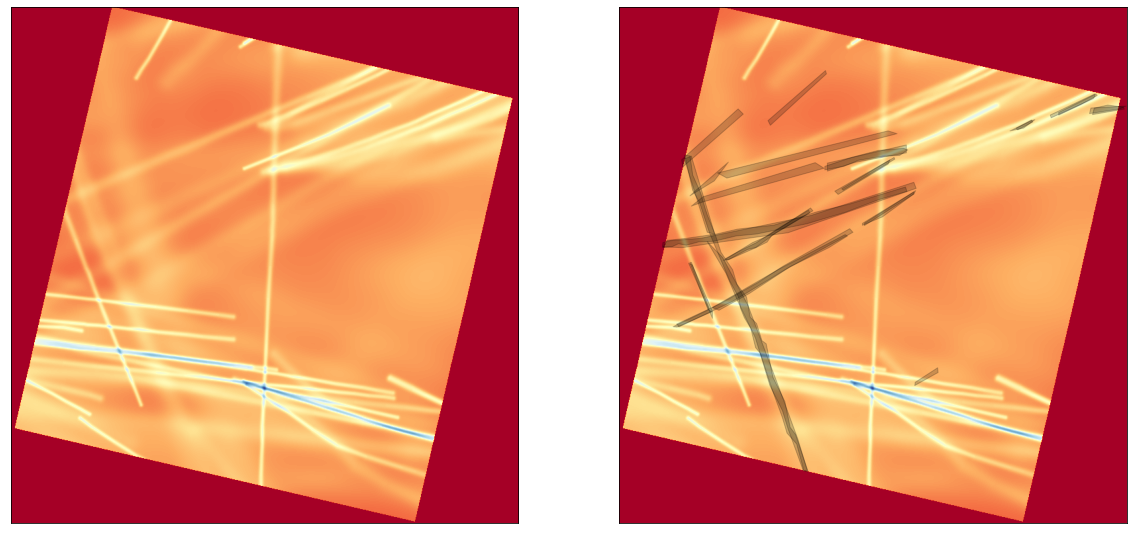

In [11]:
flight_density = np.array(scene_data['advected_flight_density'])
flight_density = np.where(np.isfinite(features[TDIFF]), flight_density, 0)

plt.figure(figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.imshow(flight_density, cmap='RdYlBu')
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(1, 2, 2)
ax.imshow(flight_density, cmap='RdYlBu')
ax.set_xticks([])
ax.set_yticks([])
patches = []
for polygon in scene_data['polygons']:
  patches.append(matplotlib.patches.Polygon(np.array(polygon), True, color=[0, 0, 0]))
p = matplotlib.collections.PatchCollection(patches, alpha=0.2, match_original=True)
ax.add_collection(p)